# Skyscrapper Solutions
### Classification Predict

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

In [108]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

### Introduction

Many companies are built around lessening their environmental impact or carbon footprint. They offer products and services that are environmentally friendly and sustainable, in line with their values and ideals. They would like to determine how people perceive climate change and whether or not they believe it is a real threat. This would add to their market research efforts in gauging how their product/service may be received.

### The task
With this context, we've been tasked with creating a Machine Learning model that is able to classify whether or not a person believes in climate change, based on their novel tweet data.

### The benefit
The goal is to provide an accurate and robust solution that gives companies access to a broad base of consumer sentiment, spanning multiple demographic and geographic categories - thus increasing their insights and informing future marketing strategies.

### Data Description:
The collection of this data was funded by a Canada Foundation for Innovation JELF Grant to Chris Bauch, University of Waterloo. This dataset aggregates tweets pertaining to climate change collected between Apr 27, 2015 and Feb 21, 2018. In total, 43943 tweets were collected. The data was downloaded from: https://www.kaggle.com/c/edsa-climate-change-belief-analysis-2022/data

Each tweet is labelled as one of the following classes:

Class Description
* 2 News: the tweet links to factual news about climate change
* 1 Pro: the tweet supports the belief of man-made climate change
* 0 Neutral: the tweet neither supports nor refutes the belief of man-made climate change
* -1 Anti: the tweet does not believe in man-made climate change

Variable definitions
- sentiment: Sentiment of tweet
- message: Tweet body
- tweetid: Twitter unique id

### Data and Library Imports
Now we will import the libraries required to perform:
* the comet experiment tracking
* language manipulation
* data import, manipulation and visualisation

#### Comet
Comet is a Machine Learning (ML) platform which allows you to track, compare, and reproduce your ML experiments..

#### Libraries
Next we will import the libraries for data importing, manipulation, visualisation, modelling and evaluation.

In [1]:
# Library imports

# Comet experimentation
from comet_ml import Experiment # running experiments

# Data manipulation and visualisation
import pandas as pd # Data manipulation
import numpy as np # Mathematical processing 
import matplotlib.pyplot as plt # Data visualisation
import seaborn as sns # Data visualisation
from wordcloud import WordCloud # Creating word clouds
%matplotlib inline
sns.set()

# Text manipulation
import string # For punctuation removal
import nltk # Toolkit for language processing
from nltk.corpus import stopwords # Redundant words
import re # Regular expression for text extraction
from nltk.tokenize import TreebankWordTokenizer # Tokenizing words
from nltk.stem import PorterStemmer # Stemming tool
from nltk import WordNetLemmatizer # Lemmatizing tool

# Model building and experimentation and evaluation
from sklearn.utils import resample
from sklearn.utils import check_X_y
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import feature_extraction
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score

from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold

import pickle

import warnings

warnings.filterwarnings('ignore')

#### Load the dataset:

Next we will import the test and train data provided. Thereafter we will inspect the shape as well as the first 5 rows of the train data to get an understanding of the data.

In [66]:
train_df = pd.read_csv('train.csv')
print('The shape of the data is:', train_df.shape)
train_df.head()

The shape of the data is: (15819, 3)


,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT @RawStory: Researchers say we have three ye...,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954


The train data consists of 15,819 rows and 3 columns which include the `sentiment`, `message` and the `tweetid`. It appears the sentiment column is in line with the class descriptions above and that messages contain alpha-numeric  characters.

Next we will look at the table information to get an understanding of the record counts, including any null values, as well as the column types.

In [3]:
# Display train datatype information:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15819 entries, 0 to 15818
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  15819 non-null  int64 
 1   message    15819 non-null  object
 2   tweetid    15819 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 370.9+ KB


The information above confirms that there are 15,819 records in the features as well as the label. So no null values to deal with. The `sentiment`, the label, and `tweetid`, a feature is of type Int while the `message` is of type object.

Let's confirm that the sentiment values conform to the description above and next obtain a view of the data samples for each sentiment.

### Exploratory Data Analysis:

In [4]:
# Identify the sentiment values
sentiment_labels = list(train_df.sentiment.unique())
print('The sentiment labels are:', sentiment_labels)

The sentiment labels are: [1, 2, 0, -1]


We will now create a barplot that will help us view and understand the distribution of the Classes (sentiments).

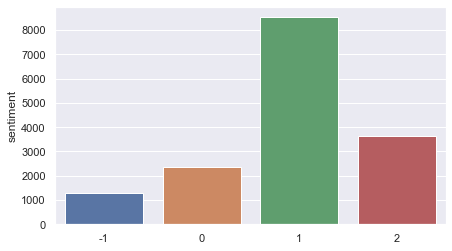

In [5]:
plt.figure(figsize=(7,4))
sns.barplot(data=train_df, x=train_df['sentiment'].unique(), y=train_df['sentiment'].value_counts())
plt.show()

From the bar graph above we discover that the majority of tweets are classified as pro the belief that climate change is man-made, followed by factual news, then neutral content and lastly tweets that show the believe that climate change is not man-made.

The graph also indicates a severe class imbalance skewed in favour of pro-climate change messages, identified as `sentiment 1`. The challenge of working with imbalanced datasets is that there are too few examples of the minority class, `sentiment -1` for a model to effectively learn the decision boundary; the space that separates once class from another. The model will therefor perform poorly.

In [67]:
# Class Percentages:
news = train_df[train_df['sentiment'] == 2]
print("News: {}%".format(round(100 * (len(news) / (len(train_df))))))

pro = train_df[train_df['sentiment'] == 1]
print("Pro: {}%".format(round(100 * (len(pro) / (len(train_df))))))

neutral = train_df[train_df['sentiment'] == 0]
print("Neutral: {}%".format(round(100 * (len(neutral) / (len(train_df))))))

anti = train_df[train_df['sentiment'] == -1]
print("Anti: {}%".format(round(100 * (len(anti) / (len(train_df))))))


News: 23%
Pro: 54%
Neutral: 15%
Anti: 8%


From the percentage splits above, we can note that there is a very distinct imbalance in the distribution of the classes, With Class 1(Pro) having a significantly higher number of samples than all the other classes. This will limit the accuracy of any model generated from this data such that it will be better at identifying a single class as opposed to others.

The solution to this may be to apply a resampling technique or a combination of multiple techniques (downsampling + upsampling) to balance out the classes.

From the distribution graph above it appears that `sentiment 2` provides the optimal data range to which to down- and upsize. Next we will identify the exact number of records in this class.

In [68]:
# 1. Establishing a Class Size:
class_size = int(len(news)) # Half the size of the pro (majority class) == 4265
print('There are', class_size, 'records in class 2 (News).')

There are 3640 records in class 2 (News).


Next we will downsample the majority class to equal 3,640 records to match the news class.

In [69]:
# Downsample the majority class size 
pro_ds = resample(pro, replace=False, # sample without replacement 
                  n_samples=class_size, # match class_size
                  random_state=27) # reproducible results

# Combine downsampled majority class with minority class
downsampled = pd.concat([pro_ds, news, neutral, anti])

# Check new class counts
print('Class 1 has been downsampled, as evident below:')
downsampled['sentiment'].value_counts()

Class 1 has been downsampled, as evident below:


 1    3640
 2    3640
 0    2353
-1    1296
Name: sentiment, dtype: int64

Next, we provide a barplot to showcase the downsampling of class 1.

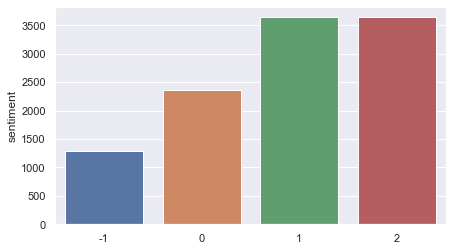

In [10]:
plt.figure(figsize=(7,4))
sns.barplot(data=downsampled, x=downsampled['sentiment'].unique(), y=downsampled['sentiment'].value_counts())
plt.show()

Next we will create dataframe for only downsampled data in order to test the model performance with it.

In [70]:
train_df = downsampled
train_df = train_df.reset_index(drop=True)
print('The new shape of the data is ', end='')
print(train_df.shape[0], 'rows and', train_df.shape[1],'columns' )

The new shape of the data is 10929 rows and 3 columns


Next we will upsample the minority class to equal 3,640 records to match the class 1 and 2.

In [11]:
# 3. Upsample the minority class size 

news_up = resample(news,
                   replace=True, # Sample with replacement (we need to duplicate observations)
                   n_samples=class_size, # Match class_size
                   random_state=27) # Reproducible results

neutral_up = resample(neutral,
                      replace=True, # sample with replacement (we need to duplicate observations)
                      n_samples=class_size, # match class_size
                      random_state=27) # reproducible results

anti_up = resample(anti,
                   replace=True, # sample with replacement (we need to duplicate observations)
                   n_samples=class_size, # match class_size
                   random_state=27) # reproducible results

# Combine downsampled majority class with minority class
upsampled = pd.concat([pro_ds, news_up, neutral_up, anti_up])

# Check new class counts
print('Class -1 and 0 have been upsampled, as evident below:')
upsampled['sentiment'].value_counts()

Class -1 and 0 have been upsampled, as evident below:


 1    3640
 2    3640
 0    3640
-1    3640
Name: sentiment, dtype: int64

Next, we provide a barplot to showcase the upsampling of class -1 and 0.

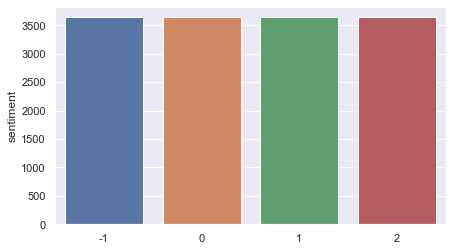

In [10]:
plt.figure(figsize=(7,4))
sns.barplot(data=upsampled, x=upsampled['sentiment'].unique(), y=upsampled['sentiment'].value_counts())
plt.show()

Next we will update the dataframe to reflect the resampled data structure which is the upsampled minority classes and downsampled majority class.

In [12]:
train_df = upsampled
train_df = train_df.reset_index(drop=True)
print('The new shape of the data is ', end='')
print(train_df.shape[0], 'rows and', train_df.shape[1],'columns' )

The new shape of the data is 14560 rows and 3 columns


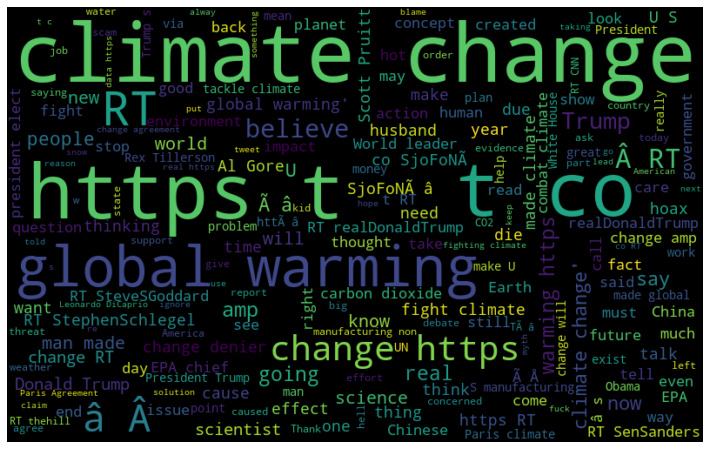

In [14]:
# Display/Visualize Frequent words:
all_words = " ".join([sentence for sentence in train_df['message']])

wc = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(all_words)

# Plot the graph:
plt.figure(figsize=(15,8))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

From the overall word cloud above we discovered that much of the information pertained to Donald Trump and his policy views. On further investigation we found that the data coincided with the 2016 US elections that Mr. Trump won. So much of the twitter data was politically charged at that time, focused on issues around the campaigns, staff members as well as policy views and research. Therefor the data may not be representative of the general sentiment towards climate change. This is confirmed by the subsequent word clouds below.

The next word cloud pertains the word usage within news `sentiment 2` tweets.

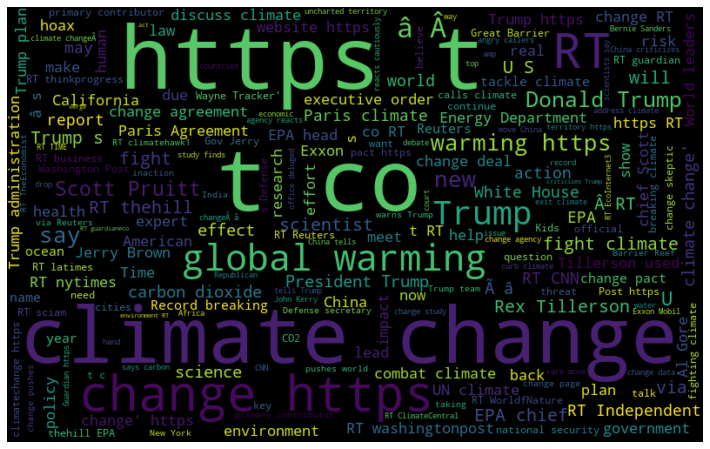

In [14]:
# Visualize Frequent words for 'News' (2) -climate change: 
news_words = " ".join([sentence for sentence in train_df['message'][train_df['sentiment'] == 2]])

wc = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(news_words)

# Plot the graph:
plt.figure(figsize=(15,8))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

The next word cloud pertains the word usage within Pro-climate change `sentiment 1` tweets.

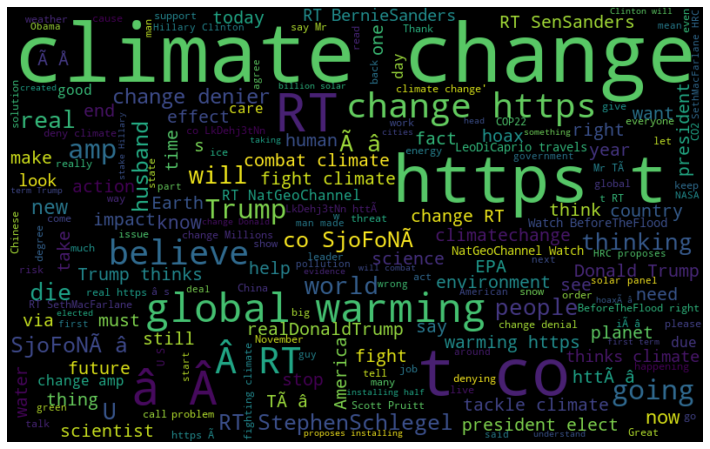

In [15]:
# Visualize Frequent words for 'Pro' (1) -climate change: 
pro_words = " ".join([sentence for sentence in train_df['message'][train_df['sentiment'] == 1]])

wc = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(pro_words)

# Plot the graph:
plt.figure(figsize=(15,8))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

The next word cloud pertains the word usage within Neutral `sentiment 0` tweets.

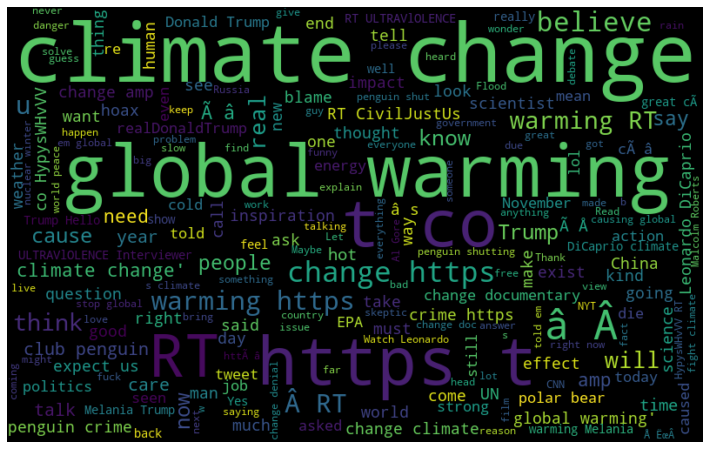

In [16]:
# Visualize Frequent words for 'Neutral' (0) -climate change: 
neutral_words = " ".join([sentence for sentence in train_df['message'][train_df['sentiment'] == 0]])

wc = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(neutral_words)

# Plot the graph:
plt.figure(figsize=(15,8))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

The next word cloud pertains the word usage within Anti-climate change `sentiment -1` tweets.

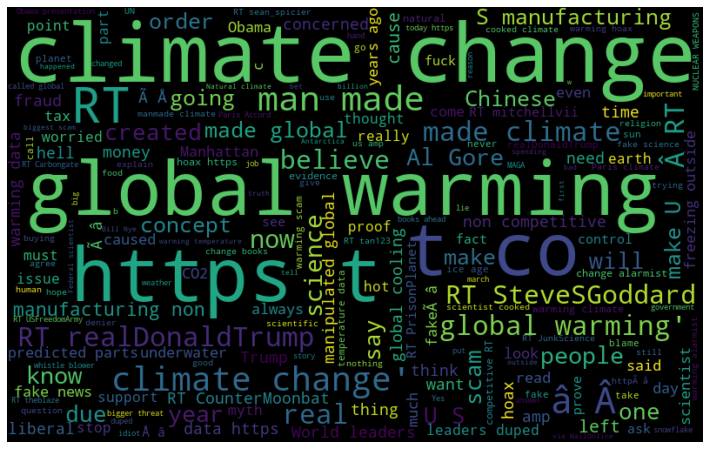

In [17]:
# Visualize Frequent words for 'Anti' (-1) -climate change: 
anti_words = " ".join([sentence for sentence in train_df['message'][train_df['sentiment'] == -1]])

wc = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(anti_words)

# Plot the graph:
plt.figure(figsize=(15,8))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

### Pre Processing

Next we clean the message text to ensure that the data is in a usable format. First let's take a look at a message to see what kind of content we can expect to find.

In [12]:
# Select the first tweet
train_df['message'].iloc[0]

"RT @ubcforestry: Funding from @GenomeBC will support @SallyNAitken's team as they address the impact of climate change on trees.…"

From the message above we observe that messages may contain web-urls, punctuation, upper and lower case characters.

### Removing Noise
Next we will remove unnecessary information, as seen above. These include web-urls, punctuation, special characters and stop-words. We will also convert the text to lower-case.

In [71]:
# Cleanup / Remove pattern:

def cleaner(text):
    text  = re.sub(r'@[A-Za-z0-9_]+', '', text)
    text = re.sub(r'[#]', '', text)
    text = re.sub(r'RT : ', '', text)
    text = re.sub(r'https?:\/\/[A-Za-z0-9\.\/]+', 'url', text)
    text = re.sub(r"www.\S+", "", text)
    text = re.sub("[^A-Za-z]"," ", text)
    text = re.sub(r'[...]', '', text)
    return text

In [72]:
train_df['clean_message'] = train_df['message'].apply(cleaner)

In [73]:
# Function to remove punctuation
def remove_punctuation(message):
    """this function removes punctuation from tweets"""
    return ''.join([l for l in message if l not in string.punctuation])

In [74]:
train_df['clean_message'] = train_df['clean_message'].apply(remove_punctuation)

In [75]:
train_df.head()

,sentiment,message,tweetid,clean_message
0,1,RT @ubcforestry: Funding from @GenomeBC will s...,977844,Funding from will support s team as they add...
1,1,@YadiMoIina gag orders? Sure. He's definitely ...,441956,gag orders Sure He s definitely green and d...
2,1,RT @pattonoswalt: Not ominous at all! (He also...,978938,Not ominous at all He also wants the names o...
3,1,RT @MelissaJPeltier: In case you forgot about ...,587737,In case you forgot about that Chinese Hoax g...
4,1,RT @SethMacFarlane: HRC proposes installing ha...,804767,HRC proposes installing half a billion solar p...


#### Tokenization
Next we tokenize the cleaned text by splitting the entire text blocks word units.

In [76]:
# Converting Tweet Messages into Tokens(word-lists):
tokenizer = TreebankWordTokenizer()
train_df['clean_message'] = train_df['clean_message'].apply(tokenizer.tokenize)
train_df.head()

,sentiment,message,tweetid,clean_message
0,1,RT @ubcforestry: Funding from @GenomeBC will s...,977844,"[Funding, from, will, support, s, team, as, th..."
1,1,@YadiMoIina gag orders? Sure. He's definitely ...,441956,"[gag, orders, Sure, He, s, definitely, green, ..."
2,1,RT @pattonoswalt: Not ominous at all! (He also...,978938,"[Not, ominous, at, all, He, also, wants, the, ..."
3,1,RT @MelissaJPeltier: In case you forgot about ...,587737,"[In, case, you, forgot, about, that, Chinese, ..."
4,1,RT @SethMacFarlane: HRC proposes installing ha...,804767,"[HRC, proposes, installing, half, a, billion, ..."


#### Stop words
Next well remove all of the English stopwords from the message by first creating a removal function and then applying the function to the dataset.

In [77]:
def remove_stop_words(tokens):    
    return [t for t in tokens if t not in stopwords.words('english')]

In [78]:
train_df['clean_message'] = train_df['clean_message'].apply(remove_stop_words)

#### Lemmatization:
Next we will lemmatize the words i.e. produce the canonical form of each word.

In [79]:
lemmatizer = WordNetLemmatizer()
train_df['clean_message'] = train_df['clean_message'].apply(lambda sentence: [lemmatizer.lemmatize(word) for word in sentence])
train_df.head()

,sentiment,message,tweetid,clean_message
0,1,RT @ubcforestry: Funding from @GenomeBC will s...,977844,"[Funding, support, team, address, impact, clim..."
1,1,@YadiMoIina gag orders? Sure. He's definitely ...,441956,"[gag, order, Sure, He, definitely, green, thin..."
2,1,RT @pattonoswalt: Not ominous at all! (He also...,978938,"[Not, ominous, He, also, want, name, anyone, w..."
3,1,RT @MelissaJPeltier: In case you forgot about ...,587737,"[In, case, forgot, Chinese, Hoax, global, warm..."
4,1,RT @SethMacFarlane: HRC proposes installing ha...,804767,"[HRC, proposes, installing, half, billion, sol..."


In [80]:
# Revert back to sentence:

for i in range(len(train_df['clean_message'])):
    train_df['clean_message'][i] = " ".join(train_df['clean_message'][i])

train_df.head()

,sentiment,message,tweetid,clean_message
0,1,RT @ubcforestry: Funding from @GenomeBC will s...,977844,Funding support team address impact climate ch...
1,1,@YadiMoIina gag orders? Sure. He's definitely ...,441956,gag order Sure He definitely green think clima...
2,1,RT @pattonoswalt: Not ominous at all! (He also...,978938,Not ominous He also want name anyone working c...
3,1,RT @MelissaJPeltier: In case you forgot about ...,587737,In case forgot Chinese Hoax global warming url...
4,1,RT @SethMacFarlane: HRC proposes installing ha...,804767,HRC proposes installing half billion solar pan...


In [81]:
train_df = train_df.drop(['message'], axis=1)
train_df.head()

,sentiment,tweetid,clean_message
0,1,977844,Funding support team address impact climate ch...
1,1,441956,gag order Sure He definitely green think clima...
2,1,978938,Not ominous He also want name anyone working c...
3,1,587737,In case forgot Chinese Hoax global warming url...
4,1,804767,HRC proposes installing half billion solar pan...


### Feature Engineering:

#### Count Vectorizer:

Next we will select a vectorizer with which to create text vectors.

CountVectorizer is be used to transform a given text into a vector on the basis of the frequency (count) of each word that occurs in the entire text.

TfidfVectorizer uses an in-memory vocabulary (a python dictionary) to map the most frequent words to features indices and hence compute a word occurrence frequency (sparse) matrix.

In [82]:
vectorize_select = 2

if vectorize_select == 1:
    vectorizer = CountVectorizer(stop_words='english', 
                                 min_df=2, 
                                 max_df=0.5, 
                                 ngram_range=(2, 10))
elif vectorize_select == 2:
    vectorizer = TfidfVectorizer(lowercase=True, analyzer='word')
else:
    vectorizer = feature_extraction.text.TfidfVectorizer(
    ngram_range=(1,3),
    analyzer='char'
    )








#### Splitting Dataset into Features and Labels:

In [83]:
X = train_df['clean_message']
y = train_df['sentiment']

In [84]:
# Train-Test Split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=45, stratify=y) # 

#### Feature Extraction:


In [85]:
x_train = vectorizer.fit_transform(x_train)
x_test = vectorizer.transform(x_test)

### Model Testing, Performance Evaluation and Logging
Next we will test a variety of models, produce evaluation matrices and create pickle files for model reuse. The models include:
1. K Nearest Neighbor with 'neigh.pkl' as pickle.
2. Random Forest,'rf_clf.pkl' as pickle.
3. Naive Bayes (Multinomial),'nbm_clf.pkl' as pickle.
4. Logistic Regression,'lr_model.pkl' as pickle.
5. Gradient Boost,'gboost.pkl' as pickle.
6. Naive Bayes (Complement), 'nbc.pkl' as pickle.
7. Support Vector, 'svm.pkl' as pickle.

The function below evaluates the model's performance and returns the performance metrics to the Comet for experiment logging.

In [86]:
# Model performance evaluation and Comet experimentation
labels = ['-1','0','1','2']
performance_dict = {}

def show_performance_data(y_test, y_pred, model_name):
    """This function evaluates each model performance and sends the 
    experiment to Comet while also saving the metric to a 
    dictionary for later use."""
    
    # Create a Comet linked experiment with api key
    experiment = Experiment(
        api_key="uSjPrOwXQdE1GLSEQuhuEJ1QQ",
        project_name="climate-change-sentiment",
        workspace="stanfordgibson",
    )
    
    print(classification_report(y_test, y_pred, target_names=labels))
    tmp_result = classification_report(y_test, y_pred, target_names=labels, output_dict=True)
    
    cm1 = confusion_matrix(y_test, y_pred)
    df_cm = pd.DataFrame(cm1, index = [i for i in labels], columns = [i for i in labels])
    plt.figure(figsize = (7,5))
    sns.heatmap(df_cm, annot=True, cmap='gist_earth_r', fmt='g')
    plt.savefig('confusion_mrtx_'+model_name+'.png',bbox_inches = 'tight')

    accuracy = tmp_result['accuracy']                          
    weighted_precision =  tmp_result['weighted avg']['precision'] 
    weighted_recall = tmp_result['weighted avg']['recall']    
    weighted_f1 = tmp_result['weighted avg']['f1-score']

    # Comet metrics
    metrics = {"Accuracy": accuracy,
               "f1":weighted_f1,
               "recall":weighted_recall,
               "precision":weighted_precision
    }
    
    # Populate the Performance dictionary
    performance_dict[model_name] = {'accuracy':accuracy, 
                                    'f1':weighted_f1, 
                                    'precision':weighted_precision, 
                                    'recall':weighted_recall }

    experiment.log_dataset_hash(x_train)
    experiment.log_parameters(params)
    experiment.log_metrics(metrics)
    experiment.end()
    
    return tmp_result

### KNN Model
K-nearest neighbors algorithm is a non-parametric supervised learning method used for classification and regression. In both cases, the input consists of the k closest training examples in a data set.

The best parameters for KNN are:

{'algorithm': 'auto', 'leaf_size': 1, 'n_jobs': -1, 'n_neighbors': 8}


COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/stanfordgibson/climate-change-sentiment/e2c4a630c8434b1097e2f2152397b28b



              precision    recall  f1-score   support

          -1       0.53      0.42      0.47       259
           0       0.50      0.49      0.50       471
           1       0.58      0.55      0.56       728
           2       0.67      0.77      0.71       728

    accuracy                           0.59      2186
   macro avg       0.57      0.56      0.56      2186
weighted avg       0.59      0.59      0.59      2186



COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/stanfordgibson/climate-change-sentiment/e2c4a630c8434b1097e2f2152397b28b
COMET INFO:   Metrics:
COMET INFO:     Accuracy  : 0.5924062214089661
COMET INFO:     f1        : 0.5874738239656638
COMET INFO:     precision : 0.5869119717103557
COMET INFO:     recall    : 0.5924062214089661
COMET INFO:   Parameters:
COMET INFO:     algorithm   : auto
COMET INFO:     leaf_size   : 1
COMET INFO:     n_jobs      : -1
COMET INFO:     n_neighbors : 8
COMET INFO:   Uploads:
COMET INFO:     conda-environment-definition : 1
COMET INFO:     conda-info                   : 1
COMET INFO:     conda-specification          : 1
COMET INFO:     environment details          : 1
COMET INFO:     filename                     : 1
COMET INFO:     git metadata                 : 

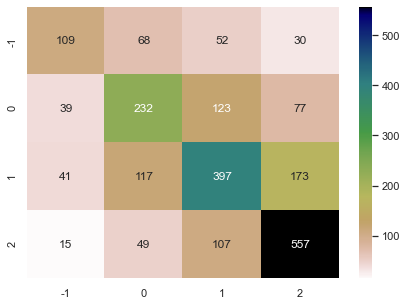

In [87]:
# Instantiate model object
knn = KNeighborsClassifier()

# Define the parameters for GridSearch
parameters = {'n_neighbors':[6,7,8],
              'leaf_size':[1],
              'algorithm':['auto', 'kd_tree'],
              'n_jobs':[-1]}

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

neigh = GridSearchCV(knn, cv=cv, param_grid=parameters)
neigh.fit(x_train, y_train)
y_pred = neigh.predict(x_test)

print('The best parameters for KNN are:', end='\n\n')
print(neigh.best_params_)

# logging for the project on Comet.ml
params = neigh.best_params_

results_knn = show_performance_data(y_test, y_pred, 'knn')

### Save model as a file

In [88]:
save_path = 'neigh.pkl'

with open(save_path, 'wb') as file:
    pickle.dump(neigh, file)

### Random Forest Classifier
Random forests or random decision forests is an ensemble learning method for classification, regression and other tasks that operates by constructing a multitude of decision trees at training time.

Fitting 30 folds for each of 2 candidates, totalling 60 fits
The best parameters for the Random Forest Classifier are:

{'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 20}


COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/stanfordgibson/climate-change-sentiment/dbd47b26733644e1b4d087b0e2c7cc1c



              precision    recall  f1-score   support

          -1       0.85      0.20      0.33       259
           0       0.54      0.45      0.49       471
           1       0.58      0.64      0.61       728
           2       0.67      0.84      0.75       728

    accuracy                           0.62      2186
   macro avg       0.66      0.53      0.54      2186
weighted avg       0.63      0.62      0.59      2186



COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/stanfordgibson/climate-change-sentiment/dbd47b26733644e1b4d087b0e2c7cc1c
COMET INFO:   Metrics:
COMET INFO:     Accuracy  : 0.6157365050320219
COMET INFO:     f1        : 0.59495533396938
COMET INFO:     precision : 0.631273117652093
COMET INFO:     recall    : 0.6157365050320219
COMET INFO:   Parameters:
COMET INFO:     max_depth         : 1
COMET INFO:     max_features      : auto
COMET INFO:     min_samples_leaf  : 3
COMET INFO:     min_samples_split : 8
COMET INFO:     n_estimators      : 20
COMET INFO:   Uploads:
COMET INFO:     conda-environment-definition : 1
COMET INFO:     conda-info                   : 1
COMET INFO:     conda-specification          : 1
COMET INFO:     environment details          : 1
COMET INFO:     filename             

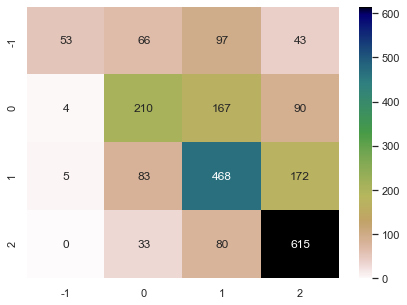

In [89]:
# Instantiate model object
rf = RandomForestClassifier(random_state=1)

# Define the parameters for GridSearch
parameters = {
    'max_depth': [None],
    'max_features': ['auto'],
    'min_samples_leaf': [3],
    'min_samples_split': [8],
    'n_estimators': [10, 20]
}

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

rf_clf = GridSearchCV(rf, param_grid=parameters, 
                     cv = cv, n_jobs=-1, verbose=1)

rf_clf.fit(x_train, y_train)
y_pred = rf_clf.predict(x_test)

print('The best parameters for the Random Forest Classifier are:', end='\n\n')
print(rf_clf.best_params_)

# logging for the project on Comet.ml
params = rf_clf.best_params_

result_rnmdfst = show_performance_data(y_test, y_pred, 'rndmfst')


#### Save model as file

In [90]:
save_path = 'rf_clf.pkl'

with open(save_path, 'wb') as file:
    pickle.dump(rf_clf, file)

### Naive Bayes (Multinomial)
A naive Bayes classifier is an algorithm that uses Bayes' theorem to classify objects. Naive Bayes classifiers assume strong, or naive, independence between attributes of data points

Fitting 30 folds for each of 2 candidates, totalling 60 fits
The best parameters for the Naive Bayes (Multinomial) Classifier are:

{'alpha': 1.0, 'class_prior': None, 'fit_prior': False}


COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/stanfordgibson/climate-change-sentiment/ddb1467f1f9c48218914d8fd8f5775b7



              precision    recall  f1-score   support

          -1       0.67      0.39      0.49       259
           0       0.68      0.40      0.50       471
           1       0.60      0.73      0.66       728
           2       0.72      0.86      0.79       728

    accuracy                           0.66      2186
   macro avg       0.67      0.60      0.61      2186
weighted avg       0.67      0.66      0.65      2186



COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/stanfordgibson/climate-change-sentiment/ddb1467f1f9c48218914d8fd8f5775b7
COMET INFO:   Metrics:
COMET INFO:     Accuracy  : 0.6628545288197621
COMET INFO:     f1        : 0.6476202488491385
COMET INFO:     precision : 0.6660068024856199
COMET INFO:     recall    : 0.6628545288197621
COMET INFO:   Parameters:
COMET INFO:     alpha       : 1.0
COMET INFO:     class_prior : 1
COMET INFO:     fit_prior   : False
COMET INFO:   Uploads:
COMET INFO:     conda-environment-definition : 1
COMET INFO:     conda-info                   : 1
COMET INFO:     conda-specification          : 1
COMET INFO:     environment details          : 1
COMET INFO:     filename                     : 1
COMET INFO:     git metadata                 : 1
COMET INFO:     git-patch (u

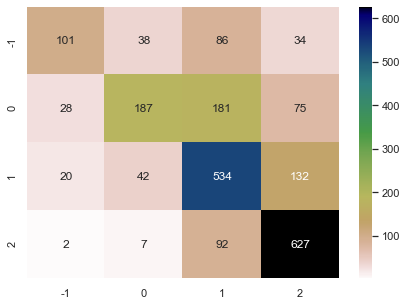

In [104]:
# Instantiate model object
nbm = MultinomialNB()

# Define the parameters for GridSearch
parameters = {
    'alpha':[1.0],
    'fit_prior':[True, False], 
    'class_prior':[None]
}

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

nbm_clf = GridSearchCV(nbm, param_grid=parameters, cv = cv, n_jobs=-1, verbose=1)

nbm_clf.fit(x_train, y_train)

y_pred = nbm_clf.predict(x_test)

print('The best parameters for the Naive Bayes (Multinomial) Classifier are:', end='\n\n')
print(nbm_clf.best_params_)

# logging for the project on Comet.ml
params = nbm_clf.best_params_

result_nbm = show_performance_data(y_test, y_pred, 'nbm')

#### Save model as file

In [105]:
save_path = 'nbm_clf.pkl'

with open(save_path, 'wb') as file:
    pickle.dump(nbm_clf, file)

### Logistic Regrssion
Logistic regression is a statistical model that in its basic form uses a logistic function to model a binary dependent variable.

Fitting 30 folds for each of 2 candidates, totalling 60 fits
The best parameters for the Logistic Regression Classifier are:

{'penalty': 'l2'}


COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/stanfordgibson/climate-change-sentiment/75ae4410e6e4468f8b917ae6d1b62639



              precision    recall  f1-score   support

          -1       0.76      0.39      0.52       259
           0       0.60      0.51      0.55       471
           1       0.63      0.70      0.67       728
           2       0.75      0.87      0.81       728

    accuracy                           0.68      2186
   macro avg       0.69      0.62      0.64      2186
weighted avg       0.68      0.68      0.67      2186



COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/stanfordgibson/climate-change-sentiment/75ae4410e6e4468f8b917ae6d1b62639
COMET INFO:   Metrics:
COMET INFO:     Accuracy  : 0.6806953339432754
COMET INFO:     f1        : 0.6706333111665737
COMET INFO:     precision : 0.6806211581224236
COMET INFO:     recall    : 0.6806953339432754
COMET INFO:   Parameters:
COMET INFO:     penalty : l2
COMET INFO:   Uploads:
COMET INFO:     conda-environment-definition : 1
COMET INFO:     conda-info                   : 1
COMET INFO:     conda-specification          : 1
COMET INFO:     environment details          : 1
COMET INFO:     filename                     : 1
COMET INFO:     git metadata                 : 1
COMET INFO:     git-patch (uncompressed)     : 1 (8.62 MB)
COMET INFO:     installed packages        

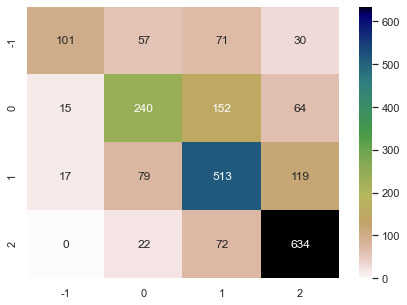

In [93]:
# Instantiate model object
lr = LogisticRegression(random_state=0)

# Define the parameters for GridSearch
parameters = {'penalty':['l1', 'l2']
}

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

lr_clf = GridSearchCV(lr, param_grid=parameters, cv = cv, n_jobs=-1, verbose=1)

lr_clf.fit(x_train, y_train)

y_pred = lr_clf.predict(x_test)

print('The best parameters for the Logistic Regression Classifier are:', end='\n\n')
print(lr_clf.best_params_)

# logging for the project on Comet.ml
params = lr_clf.best_params_

result_lr = show_performance_data(y_test, y_pred, 'lr')

#### Save model as file

In [94]:
save_path = 'lr_model.pkl'

with open(save_path, 'wb') as file:
    pickle.dump(lr_clf, file)

### Gradient Boost Classifier
Gradient boosting classifiers are a group of machine learning algorithms that combine many weak learning models together to create a strong predictive model. 

Fitting 30 folds for each of 1 candidates, totalling 30 fits
The best parameters for the Logistic Regression Classifier are:

{'learning_rate': 1.0, 'max_depth': 1, 'n_estimators': 10}


COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/stanfordgibson/climate-change-sentiment/5da276f49afd4ea0ad8800dae99d7081



              precision    recall  f1-score   support

          -1       0.71      0.26      0.38       259
           0       0.51      0.44      0.47       471
           1       0.57      0.55      0.56       728
           2       0.63      0.84      0.72       728

    accuracy                           0.59      2186
   macro avg       0.60      0.52      0.53      2186
weighted avg       0.59      0.59      0.57      2186



COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/stanfordgibson/climate-change-sentiment/5da276f49afd4ea0ad8800dae99d7081
COMET INFO:   Metrics:
COMET INFO:     Accuracy  : 0.5901189387008234
COMET INFO:     f1        : 0.5728191201426015
COMET INFO:     precision : 0.5919703776711895
COMET INFO:     recall    : 0.5901189387008234
COMET INFO:   Parameters:
COMET INFO:     learning_rate : 1.0
COMET INFO:     max_depth     : 1
COMET INFO:     n_estimators  : 10
COMET INFO:   Uploads:
COMET INFO:     conda-environment-definition : 1
COMET INFO:     conda-info                   : 1
COMET INFO:     conda-specification          : 1
COMET INFO:     environment details          : 1
COMET INFO:     filename                     : 1
COMET INFO:     git metadata                 : 1
COMET INFO:     git-patch

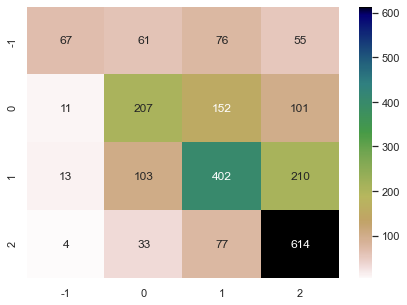

In [95]:
# Instantiate model object
gb = GradientBoostingClassifier(random_state=0)

# Define the parameters for GridSearch
parameters = {'n_estimators': [10],
              'learning_rate':[1.0],
              'max_depth':[1]
}

# Set the folds
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# Perform GridSearchCV
gb_clf = GridSearchCV(gb, param_grid=parameters, cv = cv, n_jobs=-1, verbose=1)

# Fit the best performing model
gb_clf.fit(x_train, y_train)

# Perform the prediction
y_pred = gb_clf.predict(x_test)

print('The best parameters for the Logistic Regression Classifier are:', end='\n\n')
print(gb_clf.best_params_)

# logging for the project on Comet.ml
params = gb_clf.best_params_

# Display the results
result_grdbst = show_performance_data(y_test, y_pred, 'grdbst')

#### Save model as file

In [96]:
save_path = 'gboost.pkl'

with open(save_path, 'wb') as file:
    pickle.dump(gb_clf, file)

### Naive Bayes (complement)
In complement Naive Bayes, instead of calculating the probability of an item belonging to a certain class, we calculate the probability of the item belonging to all the classes.

Fitting 30 folds for each of 2 candidates, totalling 60 fits
The best parameters for the Naive Bayes (Complement) Classifier are:

{'alpha': 1.0, 'class_prior': None, 'fit_prior': True}


COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/stanfordgibson/climate-change-sentiment/ad59cf0400db4642a5cb8f14b9ec2e75



              precision    recall  f1-score   support

          -1       0.63      0.51      0.56       259
           0       0.63      0.41      0.50       471
           1       0.63      0.64      0.64       728
           2       0.69      0.88      0.78       728

    accuracy                           0.66      2186
   macro avg       0.65      0.61      0.62      2186
weighted avg       0.65      0.66      0.64      2186



COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/stanfordgibson/climate-change-sentiment/ad59cf0400db4642a5cb8f14b9ec2e75
COMET INFO:   Metrics:
COMET INFO:     Accuracy  : 0.656907593778591
COMET INFO:     f1        : 0.644546693191832
COMET INFO:     precision : 0.6511104885677654
COMET INFO:     recall    : 0.656907593778591
COMET INFO:   Parameters:
COMET INFO:     alpha       : 1.0
COMET INFO:     class_prior : 1
COMET INFO:     fit_prior   : True
COMET INFO:   Uploads:
COMET INFO:     conda-environment-definition : 1
COMET INFO:     conda-info                   : 1
COMET INFO:     conda-specification          : 1
COMET INFO:     environment details          : 1
COMET INFO:     filename                     : 1
COMET INFO:     git metadata                 : 1
COMET INFO:     git-patch (uncom

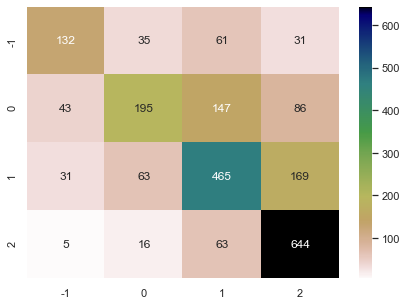

In [106]:
# Instantiate model object
nbc = ComplementNB()

# Define the parameters for GridSearch
parameters = {
    'alpha':[1.0],
    'fit_prior':[True, False], 
    'class_prior':[None],
}

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

nbc_clf = GridSearchCV(nbc, param_grid=parameters, cv = cv, n_jobs=-1, verbose=1)

nbc_clf.fit(x_train, y_train)

y_pred = nbc_clf.predict(x_test)

print('The best parameters for the Naive Bayes (Complement) Classifier are:', end='\n\n')
print(nbc_clf.best_params_)

# logging for the project on Comet.ml
params = nbc_clf.best_params_

result_nbc = show_performance_data(y_test, y_pred, 'nbc')

#### Save model as file

In [107]:
save_path = 'nbc.pkl'

with open(save_path, 'wb') as file:
    pickle.dump(nbc_clf, file)

### Support Vector Machine
The SVM maps data to a high-dimensional feature space so that data points can be categorized.

Fitting 2 folds for each of 1 candidates, totalling 2 fits
The best parameters for the Support Vector Classifier are:

{'gamma': 'auto', 'kernel': 'linear'}


COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/stanfordgibson/climate-change-sentiment/4f000e04406e441f93471ffcaba2d9e3



              precision    recall  f1-score   support

          -1       0.73      0.47      0.58       259
           0       0.60      0.53      0.56       471
           1       0.64      0.70      0.67       728
           2       0.77      0.86      0.81       728

    accuracy                           0.69      2186
   macro avg       0.69      0.64      0.66      2186
weighted avg       0.69      0.69      0.68      2186



COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/stanfordgibson/climate-change-sentiment/4f000e04406e441f93471ffcaba2d9e3
COMET INFO:   Metrics:
COMET INFO:     Accuracy  : 0.6898444647758463
COMET INFO:     f1        : 0.6840174360276592
COMET INFO:     precision : 0.6877777229955313
COMET INFO:     recall    : 0.6898444647758463
COMET INFO:   Parameters:
COMET INFO:     gamma  : auto
COMET INFO:     kernel : linear
COMET INFO:   Uploads:
COMET INFO:     conda-environment-definition : 1
COMET INFO:     conda-info                   : 1
COMET INFO:     conda-specification          : 1
COMET INFO:     environment details          : 1
COMET INFO:     filename                     : 1
COMET INFO:     git metadata                 : 1
COMET INFO:     git-patch (uncompressed)     : 1 (8.62 MB)
COMET INF

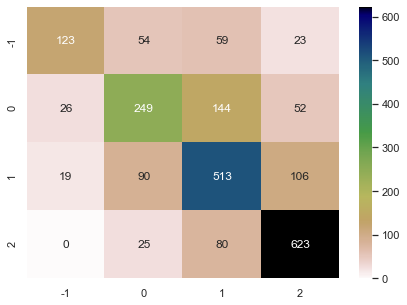

In [99]:
# Instantiate model object
svm = SVC()

# Define the parameters for GridSearch
parameters = {'gamma': ['auto'],
          'kernel': ['linear']
         }

#cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=2, random_state=1)

svm_clf = GridSearchCV(svm, param_grid=parameters, cv = 2, n_jobs=-1, verbose=1)

svm_clf.fit(x_train, y_train)

y_pred = svm_clf.predict(x_test)

print('The best parameters for the Support Vector Classifier are:', end='\n\n')
print(svm_clf.best_params_)

# logging for the project on Comet.ml
params = svm_clf.best_params_

result_svm = show_performance_data(y_test, y_pred, 'svm')

#### Save model as file

In [100]:
save_path = 'svm.pkl'

with open(save_path, 'wb') as file:
    pickle.dump(svm, file)

### Model Evaluation

Next we will compare each model's performance in the following cases:
1. The models' performance with unbalanced data.
2. The models' performance with only the majority class data down-sampled.
3. The models' performance with the majority class data down-sampled and the minority class data up-sampled.

We will use the f1 score, which is used to check the balance between precision and recall, to determine which model performed best. The accuracy is an indication of the total predictions (class allocations) which are correct. While precision measures how many predictions out of positive class predictions were correct. Recall measures that Out of total positives class predictions, how were correctly identified.


#### 1. The models' performance with unbalanced data.

In [ ]:
# Convert performance metrics into a dataframe
df = pd.DataFrame(performance_dict)

# Export performance metrics to csv
df.to_csv('MetricsUnbalanced.csv')


Below is a table of the model performance on unbalanced data

      metric       knn   rndmfst       nbm        lr    grdbst       nbc  \
0   accuracy  0.632743  0.666245  0.699747  0.711125  0.617889  0.694058   
1         f1  0.622626  0.622512  0.672456  0.690911  0.575022  0.677152   
2  precision  0.621918  0.683880  0.692275  0.708003  0.614082  0.681435   
3     recall  0.632743  0.666245  0.699747  0.711125  0.617889  0.694058   

        svm  
0  0.721871  
1  0.706499  
2  0.713881  
3  0.721871  

Below is a graphical representation of the performance


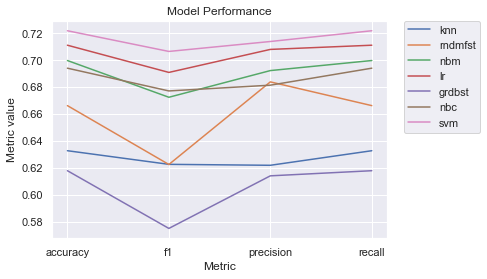

In [63]:
df = pd.read_csv('MetricsUnbalanced.csv')

# Change column name
df.rename(columns={'Unnamed: 0':'metric'}, inplace=True)
print('\nBelow is a table of the model performance on unbalanced data', end='\n\n')
print(df)


col_list = list(df.columns)
col_list.remove('metric')

print('\nBelow is a graphical representation of the performance')

# Matplotlib graph of performance
fig = plt.figure()
ax = plt.axes()

for col in col_list:
    plt.plot(df.metric, df[col])

plt.title('Model Performance')
plt.xlabel('Metric')
plt.ylabel('Metric value')
plt.legend(col_list,bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)


From the table and graph above we noted that the best performing model is the Support Vector Machine (f1: 0.71), followed by Logistic Regression (f1: 0.69) and Naive Bayes (Multinomial) (f1: 0.67)  outperformed the other models, while Gradient Boost performed the worst with an f1 score of 0.57.

#### 2. The models' performance with only the majority class data down-sampled.

In [101]:
# Convert performance metrics into a dataframe
df = pd.DataFrame(performance_dict)

# Export performance metrics to csv
df.to_csv('MajorityDSMetrics.csv')


Below is a table of the model performance on data where the majority class was down-sampled

      metric       knn   rndmfst       nbm        lr    grdbst       nbc  \
0   accuracy  0.592406  0.615737  0.662855  0.680695  0.590119  0.656908   
1         f1  0.587474  0.594955  0.647620  0.670633  0.572819  0.644547   
2  precision  0.586912  0.631273  0.666007  0.680621  0.591970  0.651110   
3     recall  0.592406  0.615737  0.662855  0.680695  0.590119  0.656908   

        svm  
0  0.689844  
1  0.684017  
2  0.687778  
3  0.689844  

Below is a graphical representation of the performance


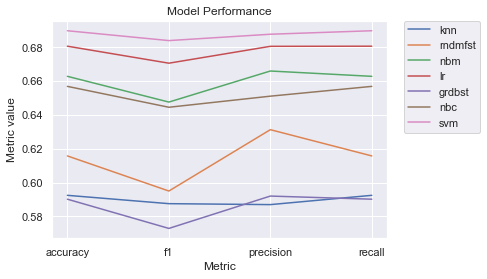

In [103]:
df = pd.read_csv('MajorityDSMetrics.csv')

# Change column name
df.rename(columns={'Unnamed: 0':'metric'}, inplace=True)
print('\nBelow is a table of the model performance on data where the majority class was down-sampled', end='\n\n')
print(df)


col_list = list(df.columns)
col_list.remove('metric')

print('\nBelow is a graphical representation of the performance')

# Matplotlib graph of performance
fig = plt.figure()
ax = plt.axes()

for col in col_list:
    plt.plot(df.metric, df[col])

plt.title('Model Performance')
plt.xlabel('Metric')
plt.ylabel('Metric value')
plt.legend(col_list,bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)


From the table and graph above we noted that the best performing model, on data where the majority class was down-sampled, is yet again the Support Vector Machine (f1: 0.68), followed by Logistic Regression (f1: 0.67) and Naive Bayes (Multinomial) (f1: 0.65), while Gradient Boost performed the worst with an f1 score of 0.57.

#### 3. The models' performance with the majority class data down-sampled and the minority class data up-sampled.

Below is summary table of each model's performance

                knn   rndmfst       nbm        lr    grdbst       nbc  \
accuracy   0.632743  0.666245  0.699747  0.711125  0.617889  0.694058   
f1         0.622626  0.622512  0.672456  0.690911  0.575022  0.677152   
precision  0.621918  0.683880  0.692275  0.708003  0.614082  0.681435   
recall     0.632743  0.666245  0.699747  0.711125  0.617889  0.694058   

                svm  
accuracy   0.721871  
f1         0.706499  
precision  0.713881  
recall     0.721871  

Below is a graphical representation of the performance


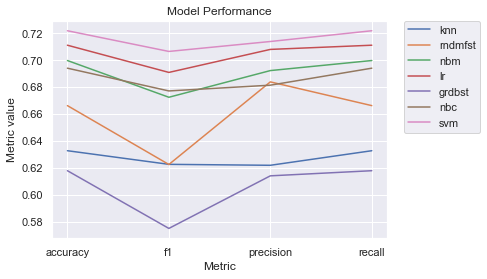

In [65]:
# Convert performance metrics into a dataframe
df = pd.DataFrame(performance_dict)
print("Below is summary table of each model's performance", end='\n\n')
print(df)
print('\nBelow is a graphical representation of the performance')

# Export performance metrics to csv
df.to_csv('Metrics.csv')

# Matplotlib graph of performance
fig = plt.figure()
ax = plt.axes()

for col in list(df.columns):
    plt.plot(df.index, df[col], label=col)

plt.title('Model Performance')
plt.xlabel('Metric')
plt.ylabel('Metric value')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

From the table and graph above we noted that the best performing model, on data where the majority class was down-sampled and the minority class up-sampled, is yet again the Support Vector Machine (f1: 0.71), followed by Logistic Regression (f1: 0.69) and Naive Bayes (Complement) (f1: 0.68), while Gradient Boost performed the worst with an f1 score of 0.58.

The consistently top performing models were Support Vector Machine, followed by Logistic Regression and Naive Bayes (Multinomial). We will therefor use these three models in the predictions as well as the sentiment analysis web application.

Furthermore, the models, trained on imbalanced data as well only the majority class downsampled, performed poorly with the test data. We will therefor train the model with overall balanced data.

### Model Predictions on the Test Dataset:
Next we will perform the predictions using the best performing model.

#### Load the Test Dataset:

In [43]:
test_df = pd.read_csv('test.csv')

In [44]:
test_df.head()

,message,tweetid
0,Europe will now be looking to China to make su...,169760
1,Combine this with the polling of staffers re c...,35326
2,"The scary, unimpeachable evidence that climate...",224985
3,@Karoli @morgfair @OsborneInk @dailykos \nPuti...,476263
4,RT @FakeWillMoore: 'Female orgasms cause globa...,872928


In [45]:
# Display train datatype information:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10546 entries, 0 to 10545
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   message  10546 non-null  object
 1   tweetid  10546 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 164.9+ KB


### Pre Processing:
Next we will pre-process the test data to ensure that the model run against the data by:
1. Applying the cleaner function
2. Applying the remove punctuation function
3. Converting text into tokens(word-lists)
4. Stemming the text
5. Lemmatizing the text
6. Removing stopwords

Thereafter we will revert the tokens back into complete sentences.

In [46]:
# Apply the cleaner function
test_df['clean_message'] = test_df['message'].apply(cleaner)

# Apply the remove punctuation function
train_df['clean_message'] = train_df['clean_message'].apply(remove_punctuation)

# Converting text into tokens(word-lists)
test_df['clean_message'] = test_df['clean_message'].apply(tokenizer.tokenize)

# Remove stopwords
test_df['clean_message'] = test_df['clean_message'].apply(remove_stop_words)

# Lemmatize the text
test_df['clean_message'] = test_df['clean_message'].apply(
    lambda sentence: [lemmatizer.lemmatize(word) for word in sentence])


# Print first five rows
test_df.head()

,message,tweetid,clean_message
0,Europe will now be looking to China to make su...,169760,"[Europe, looking, China, make, sure, alone, fi..."
1,Combine this with the polling of staffers re c...,35326,"[Combine, polling, staffer, climate, change, w..."
2,"The scary, unimpeachable evidence that climate...",224985,"[The, scary, unimpeachable, evidence, climate,..."
3,@Karoli @morgfair @OsborneInk @dailykos \nPuti...,476263,"[Putin, got, Jill, Trump, believe, climate, ch..."
4,RT @FakeWillMoore: 'Female orgasms cause globa...,872928,"[Female, orgasm, cause, global, warming, Sarca..."


In [47]:
# Revert back to sentence:
for i in range(len(test_df['clean_message'])):
    test_df['clean_message'][i] = " ".join(test_df['clean_message'][i])

test_df.head()

,message,tweetid,clean_message
0,Europe will now be looking to China to make su...,169760,Europe looking China make sure alone fighting ...
1,Combine this with the polling of staffers re c...,35326,Combine polling staffer climate change woman r...
2,"The scary, unimpeachable evidence that climate...",224985,The scary unimpeachable evidence climate chang...
3,@Karoli @morgfair @OsborneInk @dailykos \nPuti...,476263,Putin got Jill Trump believe climate change Th...
4,RT @FakeWillMoore: 'Female orgasms cause globa...,872928,Female orgasm cause global warming Sarcastic R...


Next we will drop the redundent feature; `message` since we've processed it into a new feature called `clean_message`

In [48]:
# Drop redundant feature
test_df = test_df.drop(['message'], axis=1)
test_df.head()

,tweetid,clean_message
0,169760,Europe looking China make sure alone fighting ...
1,35326,Combine polling staffer climate change woman r...
2,224985,The scary unimpeachable evidence climate chang...
3,476263,Putin got Jill Trump believe climate change Th...
4,872928,Female orgasm cause global warming Sarcastic R...


In [49]:
print("""The test data currently consists of""", test_df.shape[0],
      """rows and""",test_df.shape[1],"""features.""")

The test data currently consists of 10546 rows and 2 features.


From the information above we note that the test data consists of 10,546 records and 2 columns; the `tweetid` and the `clean_message`

Next we will load a saved model to use on the test data to make predictions.

### Load Saved Models:

In [50]:
# Select model to apply to the test data
model_to_load = 2

model_dict = {1:['KNN','neigh.pkl'],
              2: ['RandomForest','rf_clf.pkl'],
              3: ['NaiveB(Multinomial)','nbm_clf.pkl'],
              4: ['LogisticRegr','lr_model.pkl'],
              5: ['GBoost','gboost.pkl'],
              6: ['NaiveB(Complement)', 'nbc.pkl'],
              7: ['Support Vector', 'svm.pkl']
             }

model_path = model_dict[model_to_load][1]
with open(model_path, 'rb') as file:
    unpickled_model = pickle.load(file)

Next we will vectorize the test data.

In [51]:
X = test_df['clean_message']
X = vectorizer.transform(X)

In [52]:
print("""The result of the vectorization on the test data is that it now consists of""", X.shape[0],
      """rows and""",X.shape[1],"""features.""")

The result of the vectorization on the test data is that it now consists of 10546 rows and 6872 features.


### Make predictions

Next we will run the model on the vectorized test data and then create a dataframe of the predictions. The predictions will then be exported to a csv file.

In [53]:
# Test Set Predictions:
y_hat = unpickled_model.predict(X)

In [54]:
# Creating data frame for the predicted values:
predictions = pd.DataFrame()
predictions.index = test_df.index
predictions['tweetid'] = test_df.tweetid
predictions['sentiment'] = y_hat
predictions.set_index('tweetid', inplace=True)

In [55]:
# Save prediction as .csv:
predictions.to_csv('model'+ model_dict[model_to_load][0]+'.csv')